<a href="https://colab.research.google.com/github/aahFancyGun/dataScienceClass/blob/master/unit4/Copy_of_Unit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Basketball Rebounds Model

##Introduction

My project concerns the number of rebounds a player should get with their position taken into account. I'll be comparing the results of hierarchical and non-hierarchical model and discussing how and why they differ.
- I will be comparing their rhat values, generated markov chains, and actual real world usefulness between the two

##Methods

I will only be taking data from my dataset that concerns the position of a player and the total rebounds of that player
- I am assuming that the TRB will be dependent on the position of the player
- I am assuming no other factors are involved

Any players that has 0 TRB will be removed from the relevant data.



In [93]:
!pip install "preliz[full,notebook]"

In [94]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import seaborn as sns
import pymc as pm

#Data Wrangling

Data sourced from Mr. Arredondo's basketball dataset

Relevant data includes positiona and total rebounds (TRB) only

In [95]:
url = "https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv" #data url

basketball_data = pd.read_csv(url) #reading data

basketball_data #printing data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


In [96]:

scoring_data = pd.read_csv(url,dtype={'Pos':'category'}) #sorting data

scoring_data = scoring_data[["TRB", "Pos"]].copy() #taking irrelevant data out

scoring_data = scoring_data.loc[scoring_data['TRB'] != 0] #removing entries with a TRB of 0

scoring_data #printing cleaned data

,TRB,Pos
0,487,PF-C
1,737,C
2,216,SG
3,352,PF
4,167,SG
...,...,...
567,103,PF
568,149,PG
569,208,C
570,112,C


##Violin Plot

The violin plot below essentially shows each position graphed against the number of TRBs that position generally makes. For example: the "C-PF" position looks to have a mean of around 225 so we can say that the majority of the time, someone in this position will have 225 TRB.

This basically sets the stage for what I'm expecting my idea model to look like. You can see that each position's plot is distinctly different from each other so I'm expecting my distribution to also model this uniqueness.

<Axes: xlabel='TRB', ylabel='Pos'>

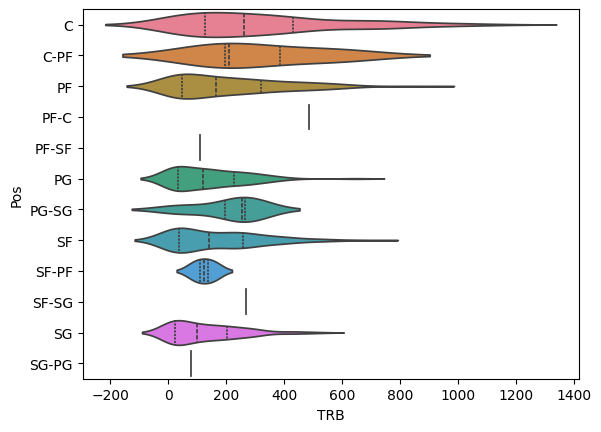

In [97]:
sns.violinplot(scoring_data, x='TRB', y='Pos', inner='quart',hue='Pos')


##Creating Categories for the model

Based off the posistion of a player

In [98]:
pos_index = scoring_data.Pos.cat.codes.values #getting indexes

pos_index #printing indexes

array([ 3,  0, 10,  2, 10, 10,  0,  7,  5,  2,  2,  2,  5,  7,  5,  7,  0,
        0,  0,  0,  5,  7,  5,  0,  2, 10,  5,  2,  2, 10, 10,  0,  7,  7,
        2,  2, 10, 10,  7, 10,  2,  5,  7,  0, 10,  0,  5,  7,  7, 10,  8,
        2,  0,  5,  7,  2, 10,  5,  5, 10,  7,  7,  7,  5,  5,  5,  7,  6,
       10,  2,  7, 10,  2,  0,  7,  5,  0, 10,  7, 10, 10,  2,  2, 10,  2,
        0,  5,  0, 10, 10,  0,  7,  7, 10,  7,  2, 10,  0,  2,  7,  2,  0,
        5,  7,  7, 10,  8,  7,  2,  5, 10,  5,  5,  0, 10, 10, 10,  7,  0,
        2, 10, 10,  2,  5, 10,  5,  7, 10,  5,  7,  0,  7, 10,  5,  2,  0,
        2, 10,  7, 10,  0,  0,  7,  5,  0,  2,  5,  7,  5, 10, 10,  5,  5,
        7,  5,  2,  1,  4,  5,  2,  0,  7,  5,  2,  2, 10,  0,  5,  2,  5,
        5,  0,  5,  2, 10,  5,  2,  2, 10, 10,  2, 10,  7,  2, 10,  7, 10,
        2,  2,  2,  5,  5,  5,  7,  5, 10, 10, 10, 10,  2, 10,  7,  0,  7,
       10,  0,  5,  7,  5,  2, 10,  9,  2, 10,  5,  5, 10,  1,  0, 10,  0,
        5,  7,  7,  7, 10

In [99]:
pos_codes = scoring_data.Pos.cat.categories #encoding categories
pos_codes #printing encoded categories

Index(['C', 'C-PF', 'PF', 'PF-C', 'PF-SF', 'PG', 'PG-SG', 'SF', 'SF-PF',
       'SF-SG', 'SG', 'SG-PG'],
      dtype='object')

In [100]:
pos_coords = {"Pos": pos_codes} #creating coordinates
pos_coords #printing

{'Pos': Index(['C', 'C-PF', 'PF', 'PF-C', 'PF-SF', 'PG', 'PG-SG', 'SF', 'SF-PF',
        'SF-SG', 'SG', 'SG-PG'],
       dtype='object')}

In [101]:
# Displaying key statistics
mean_trb_val = scoring_data['TRB'].mean()
std_trb_val = scoring_data['TRB'].std()
print("Mean of TRB:", mean_trb_val)
print("Standard deviation of TRB:", std_trb_val)
print(scoring_data.describe())

Mean of TRB: 191.27142857142857
Standard deviation of TRB: 185.68012939552352
               TRB
count   560.000000
mean    191.271429
std     185.680129
min       1.000000
25%      42.750000
50%     145.000000
75%     276.500000
max    1120.000000


#Attempted Models

##Preface

Because I do not know anything about basketball, my priors accross all of these models will generally be the same.

###Hyperpriors (same across all models)

Normal and Halfnormal models because I lack understanding of how each position plays a part in the wider game.
- My parameters consisted of mu (mean) and sigma (standard deviation)
 - Used standard deviation and mean of dataset for each parameter respectively

##Exponential

I chose exponential because in theory, it fit the shape of my data well but because it can only have one parameter at a time, it ultimate fell somewhat short of the target.

- Notably, the exponential model generated over 1000 divergences during its creation which factored into why I chose not to use it

###Priors

Exponential distributions only require one argument so I used halfnormal which only takes in sigma (standard deviation) as an argument
- I believed that this would help me model the scaling of the exponential distribution given that the height or scale of a model is related to the standard deviation

###Rhat and Trace

Because of the divergences, rhat and trace were nonsensical.
 - rhat returned many nan values
 - trace showed many nonsensical graphs

##Weibull

After exponential, I decided to choose Weibull because, after consulting documentation, it seemed like it could match my observed data well and offered an additional parameter with which I could encode my beliefs.
- Ended up having 4 divergences when I ran it
- Actually fit decently well

###Priors

Weibull takes in two parameters: Alpha (shape) and Beta (scale)
 - used StudentT to model shape because I believed it would work better than halfnormal on account of having more parameters
  - StudentT takes in standard deviation, mean, and degree of freedom
 - used halfNormal to model scale
  - Only takes in standard deviation

###Rhat, and Trace

Because of the divergences, both rhat and trace returned nonsensical values
 - rhat ended up returning many nan numbers
 - the graphs returned by trace were anomalous

##Gamma

My weibull model fit decently well and I felt that if I couldn't come up with a better model I could go with that, but I did decide to try one other distribution: Gamma.
- Gamma is pretty similar to weibull in that it shares a range of 0 to infinity
 - Has the same amount and same type of parameters but allows different parameterization with mu (mean) and sigma (standard deviation)

 In the end, Gamma ended up having several hundred divergences BUT represented the forest plot much better on account of having the ability to initialize with different parameters

##Priors

Gamma takes in two parameters: mu (mean) and sigma (std deviation)
 - used StudentT to model mean because I believed it would work better than halfnormal on account of having more parameters
  - StudentT takes in standard deviation, mean, and degree of freedom
 - used halfNormal to model std deviation
  - Only takes in standard deviation

##Rhat and Trace

will be discussed later


In [102]:
with pm.Model(coords=pos_coords) as cs_h_model:
    # hyperpriors
    μ_mu = pm.Normal('μ_mu', mu=mean_trb_val, sigma=std_trb_val * 2) # Mu hyperprior with mean and standard deviation parameters
    μ_sd = pm.HalfNormal('μ_sd', sigma=std_trb_val) # sigma hyperprior with standard deviation as parameter

    # priors interconnected via the hyperpriors
    mu = pm.StudentT('mu', mu=μ_mu, sigma=μ_sd, nu=5, dims="Pos")

    sd = pm.HalfNormal('sd', sigma=μ_sd, dims="Pos") # Access with column name

    #model
    y = pm.Gamma('y',
                  mu=mu[pos_index],  # Shape parameter
                  sigma=sd[pos_index], # Rate parameter (inverse of scale)
                  observed=scoring_data["TRB"])

    #h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 412 divergences after tuning. Increase `target_accept` or reparameterize.


In [103]:
with pm.Model(coords=pos_coords) as cs_nh_model:
    mu = pm.StudentT('mu', mu=mean_trb_val, sigma=std_trb_val, nu=5, )
    #studentT with mu (location), sigma (scale), and nu (degrees of freedom)

    sd = pm.HalfNormal('sigma', sigma=std_trb_val, ) # Access with column name

    #model
    y = pm.Gamma('y',
                  mu=mu,  # Shape parameter
                  sigma=sd, # Rate parameter (inverse of scale)
                  observed=scoring_data["TRB"])

    #nh for non-heirarchical
    idata_cs_nh = pm.sample()

Output()

Output()

#Hierarchical

Output()

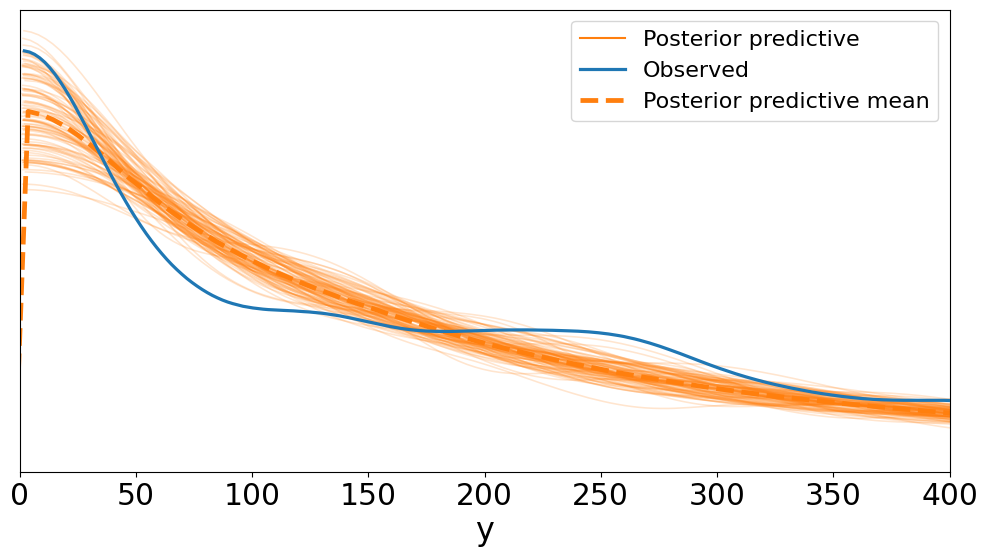

In [104]:
fig, ax = plt.subplots(figsize=(12, 6)) #creating graph

pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True) #sampling posterior predictive

az.plot_ppc(idata_cs_h, ax=ax, num_pp_samples=100, figsize=(12, 6), colors=["C1", "C0", "C1"],legend = True) #plotting posterior predictive check

ax.set_xlim(0, 400) #ensuring the graph visualizes the relevant part of the prediction

plt.show() #diplaying the graph


#Non-Hierarchical

Output()

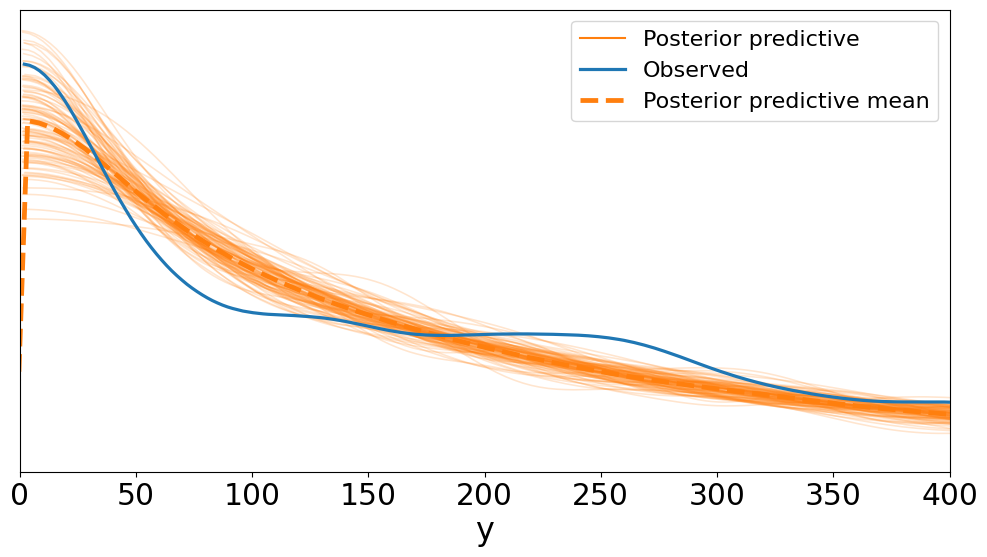

In [105]:
fig, ax = plt.subplots(figsize=(12, 6))

pm.sample_posterior_predictive(idata_cs_nh, model=cs_nh_model, extend_inferencedata=True)

az.plot_ppc(idata_cs_h, ax=ax, num_pp_samples=100, figsize=(12, 6), colors=["C1", "C0", "C1"],legend = True)

ax.set_xlim(0, 400)

plt.show()


#Forest

##(hierarchical only, requires categories which non-hierarchical doesn't account for)

So, looking at my forest, it seems to agree with the general distributions in my violin plot with positions plotted here coinciding with how they appear in violin plot of my data. For example, if we look at the "C" position, you can see that it's mean is right around ~300, meaning that this position will most likely have a TRB of around 300. This conclusion even coincides with the observed data graphed in my violin plot earlier with the "C" position hovering around 250-275!

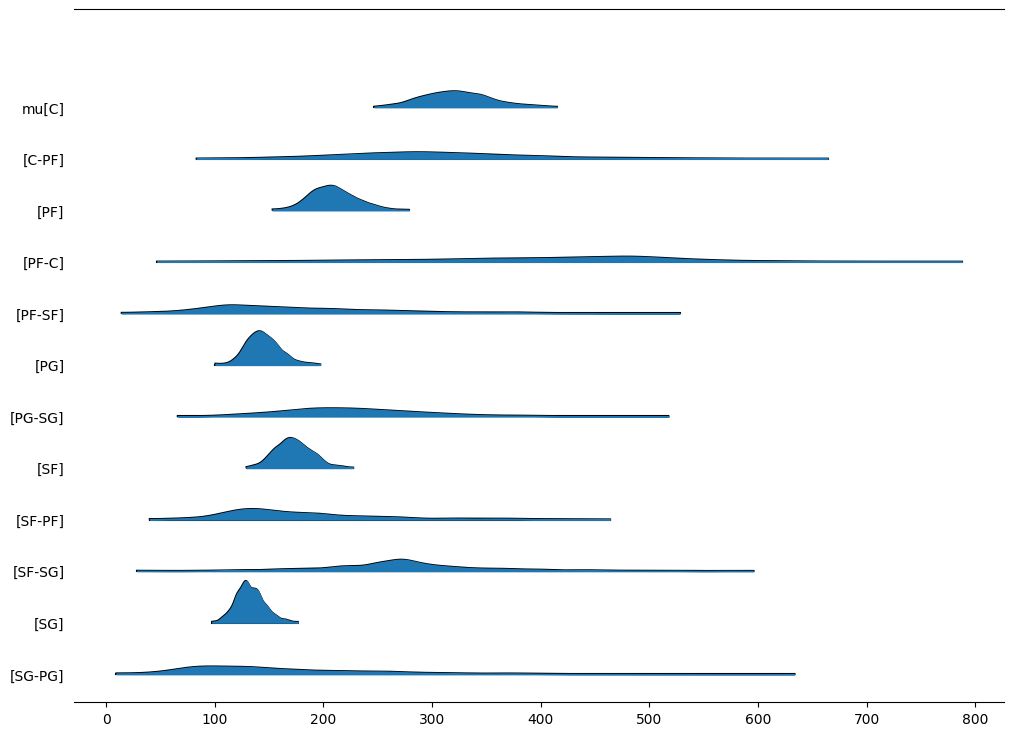

In [106]:
axes = az.plot_forest(idata_cs_h, kind="ridgeplot",
                      var_names='mu',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

#Rhat

##Hierarchical

Rhat seems to be showing somewhat bad values that are falling pretty far outside the 1-1.001 range of numbers. More specifically, my 'a' variable seems to be showing the worst of it while 'b' shows the best.

##Non-hierarchical

Rhat values here are actually significantly better than my hierarchical values which isn't too surprising considering non-hierarchical generated 0 divergences but that doesn't explain why my hierarchical model is so off.

Personally, I believe that this is a byproduct of my weak hyperpriors affecting my priors, something the non-hierarchical function doesn't have to deal with.




In [107]:
az.rhat(idata_cs_h) #rhat of h

<xarray.Dataset> Size: 448B
Dimensions:  (Pos: 12)
Coordinates:
  * Pos      (Pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    mu       (Pos) float64 96B 0.9997 1.005 1.003 1.002 ... 1.001 1.003 1.001
    sd       (Pos) float64 96B 1.0 1.002 1.002 0.9999 ... 1.003 1.004 1.004
    μ_mu     float64 8B 1.002
    μ_sd     float64 8B 1.002

In [108]:
az.rhat(idata_cs_nh) #rhat of nh

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 1.001
    sigma    float64 8B 0.9998

#Trace / Plot summary

##Hierarchical

Mostly seems fine and the different parts of each parameter and category seem to be alighning correctly. Ignoring the anomalous blackish parts that that are a result of divergence, you can see that each category traced by this function is correctly portraying how unique each position is. There is very little overlap between categories essentially.

My summary is also in accordance with that conclusion, and displays very unique standard deviation (average deviation from the mean), mean (center of that category's distribution), and hdi (where the majority of values is concentrated) values for all categories. However, it also displays the rhat values, which as discussed earlier, are pretty bad.

For example: if we look at the values in summary() for the "C" position, you can see that the mean is at 322 (the most likely value for TRB at this position), which matches the mean I estimated earlier on with my forestplot, and both are similar to the mean for that position portrayed by the actual data!

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sd'}>, <Axes: title={'center': 'sd'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'μ_sd'}>]], dtype=object)

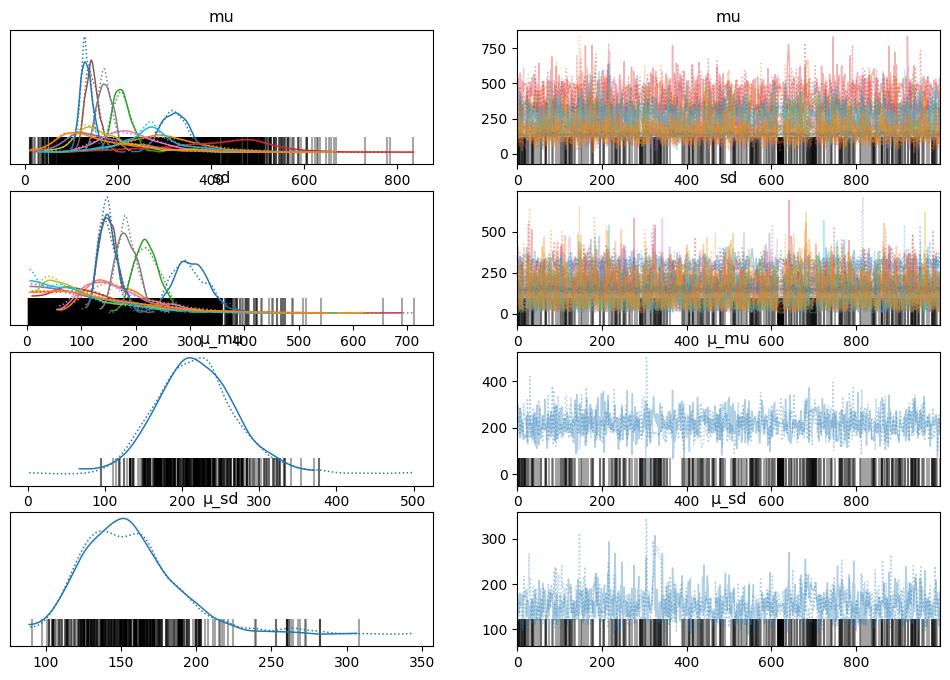

In [109]:
az.plot_trace(idata_cs_h) #getting markov chains of h model

In [110]:
az.summary(idata_cs_h) #getting summary of h model

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[C],322.507,30.692,261.334,378.157,1.039,0.750,913.0,411.0,1.0
mu[C-PF],303.259,87.921,135.860,467.855,2.918,2.269,1054.0,550.0,1.0
mu[PF],208.923,20.862,172.367,249.085,0.703,0.514,942.0,1065.0,1.0
mu[PF-C],406.451,121.878,146.873,607.630,3.555,2.515,1194.0,1129.0,1.0
mu[PF-SF],176.090,86.200,37.602,347.968,3.081,2.388,1063.0,416.0,1.0
mu[PG],144.732,15.536,116.847,173.976,0.450,0.321,1218.0,1158.0,1.0
mu[PG-SG],228.559,66.392,110.113,348.383,2.320,1.693,862.0,751.0,1.0
mu[SF],172.522,16.748,142.458,203.577,0.492,0.354,1192.0,1042.0,1.0
mu[SF-PF],177.230,71.841,69.088,335.335,3.388,2.571,606.0,374.0,1.0
mu[SF-SG],275.437,78.258,105.733,418.855,2.226,1.691,1285.0,1030.0,1.0


##Non-Hierarchical

In general this looks completely different from the hierarchical model. It's definetely a much healthier distribution with 0 divergences but that comes at a cost of actual information. The non-hierarchical does not take into account the position of a player and as a result this model can not be as specific to certain scenarios as the hierarchical one can be.

It's summary is also simplistic only showing the stats for the two priors, and comparing these values to the myriad means and standard deviations of the forestplot, and violinplot, you can see that the non-hierarchical model isn't very good at more specific scenarios.

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

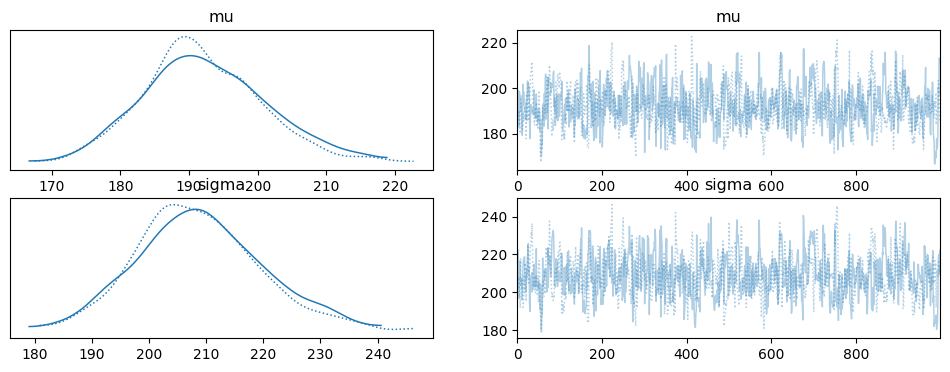

In [111]:
az.plot_trace(idata_cs_nh) #getting markov chains of nh model

In [112]:
az.summary(idata_cs_nh) #getting summary of nh model

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,192.165,9.046,175.247,209.251,0.411,0.291,478.0,670.0,1.0
sigma,208.821,11.033,188.181,230.297,0.518,0.367,451.0,655.0,1.0


#Conclusion

So what is the conclusion this model has drawn on the TRB of a player with regard to their position? Well, it's basically saying that the position matters, and greatly so. In both the forest plot and trace, a trend of difference between categories is shown, and while thats good, I still don't think that this is a good distribution for modeling reality because of how loosely both the hierarchical and non-hierarchical distributions fit the data.
 - Also consider the fact that various other factors might be involved, whereas I'm only taking into account TRB and the position of the player

Even though the two distributions had a very similar fit to the data, and even though my non-hierarchical model had fewer divergences, I still feel the hierarchical model fits the problem better. I don't know much about basketball but I do know enough to understand that position matters, and greatly so. Under the non-hierarchical model, someone playing a position that will almost never get rebounds would not be correctly represented in the slightest by that model, because it doesn't take that into account. But the Hierarchical model does, and so on a case by case basis, I feel the hierarchical model will always be more true to reality.
 - Again, I don't know anything about basketball